In [1]:
#=
    My first Julia code
=#

println("The current Julia version is v.",VERSION)

The current Julia version is v.0.5.1


#### Notes:

- We will start be doing very simple operations used in computational photography 

### Load Image

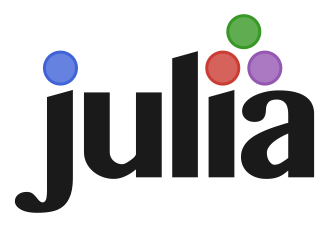

In [2]:
# load local image and display
using Images
img = load("julia_logo.png")

### Resize Image

In [21]:
println("Size of original image: ",size(img))

y_scale = convert(Int,size(img,1)/5)
x_scale = convert(Int,size(img,2)/5)

img_r = imresize(img,(y_scale,x_scale))

println("Size of new image: ",size(img_r))

Size of original image: (225,325)
Size of new image: (45,65)


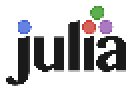

In [22]:
display(img_r)

### Applying Filter

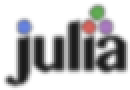

In [28]:
# applying gaussian filter on image
img_f = imfilter(img_r,Kernel.gaussian(1))

### Convert Image to Gray Scale

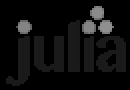

In [29]:
img_g = Gray.(img_r)